<div style="
    background-color:rgb(210, 230, 255);
    color:rgb(0, 0, 0);
    padding: 10px;
    border-radius: 10px;
    font-weight: bold;">
<h3>Modèle d'apprentissage automatique pour la prédiction d’usage le plus probable d'une friche en France</h3>
<ul>
    <li>Dans le cadre du projet PROFIL : https://github.com/heuzef/cartofriches</li>
    <li>Auteurs : Heuzef (https://heuzef.com) ; Frédéric Vincent (frederic.vincent@protonmail.com)</li>
    <li>Juin 2025</li>
    <li>Destiné au CEREMA</li>
    <li>Les données exploitées sont issues data.gouv.fr, respectant le Standard Friches (version 2022 - rev. v2023-12)</li>
</div>

# Import des librairies

In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2
import re

In [34]:
from sklearn import neighbors, svm, model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

# Fonctions utiles

In [5]:
def audit(df):
    """
    Audite un DataFrame.
    
    Paramètres:
    df (pandas.DataFrame): Le DataFrame à analyser
    
    Retourne:
    pandas.DataFrame: Un DataFrame contenant pour chaque colonne:
                     - le nombre de valeurs manquantes
                     - le pourcentage de valeurs manquantes
                     - le type de données
                     - le nombre de valeurs uniques
    """
    # Calculer le nombre de valeurs manquantes par colonne
    missing_values = df.isnull().sum()
    
    # Calculer le pourcentage de valeurs manquantes
    missing_percentage = (missing_values / len(df)) * 100
    
    # Obtenir les types de données de chaque colonne
    dtypes = df.dtypes

    # Obtenir le nombre de valeurs uniques de chaque colonne
    nunique = df.nunique()
    
    # Créer un DataFrame avec les résultats
    audit = pd.DataFrame({
        'Manquantes': missing_values,
        '(%)': missing_percentage.round(2),
        'Type': dtypes,
        'Uniques': nunique
    })
    
    # Trier par pourcentage de valeurs manquantes (décroissant)
    audit = audit.sort_values('(%)', ascending=True)
    
    return audit

# Chargement des données

In [6]:
# Chargement des données silver

df_friches_silver = pd.read_csv("./data/friches_silver.csv", sep=",", low_memory=False)

print("Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :")
print(f"{df_friches_silver.shape[0]} friches chargées — {df_friches_silver.shape[1]} variables")
print("Pas de doublon detectés")

display(df_friches_silver.head())

Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :
2331 friches chargées — 76 variables
Pas de doublon detectés


,Unnamed: 0,site_securite,site_reconv_type,bati_nombre,bati_pollution,bati_etat,proprio_personne,sol_pollution_existe,unite_fonciere_surface,longitude,...,site_type_friche_militaire,site_type_friche_portuaire,site_type_mixte,site_actu_annee,site_identif_annee,actualisation_jour,site_actu_mois_sin,site_actu_mois_cos,site_actu_jour_sin,site_actu_jour_cos
0,17,0,0,2,0,0,0,0,42877,1.337672,...,0,0,0,2024,1997,9540,0.866025,5.000000e-01,0.485302,-0.874347
1,20,0,0,2,0,1,1,0,143,-0.530774,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
2,25,0,1,0,0,0,1,0,28389,-0.546245,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
3,35,0,2,3,0,1,1,0,2619,-0.532152,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
4,45,0,1,0,0,0,1,0,60709,-0.619462,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347


# Extraction des données numériques

In [7]:
df_friches_silver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 76 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              2331 non-null   int64  
 1   site_securite                                           2331 non-null   int64  
 2   site_reconv_type                                        2331 non-null   int64  
 3   bati_nombre                                             2331 non-null   int64  
 4   bati_pollution                                          2331 non-null   int64  
 5   bati_etat                                               2331 non-null   int64  
 6   proprio_personne                                        2331 non-null   int64  
 7   sol_pollution_existe                                    2331 non-null   int64  
 8   unite_fonciere_surface                

In [8]:
df_friches_silver_numeriques = df_friches_silver.select_dtypes(exclude="object")

In [9]:
df_friches_silver_numeriques.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 76 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              2331 non-null   int64  
 1   site_securite                                           2331 non-null   int64  
 2   site_reconv_type                                        2331 non-null   int64  
 3   bati_nombre                                             2331 non-null   int64  
 4   bati_pollution                                          2331 non-null   int64  
 5   bati_etat                                               2331 non-null   int64  
 6   proprio_personne                                        2331 non-null   int64  
 7   sol_pollution_existe                                    2331 non-null   int64  
 8   unite_fonciere_surface                

In [10]:
print(audit(df_friches_silver_numeriques))

                    Manquantes  (%)     Type  Uniques
Unnamed: 0                   0  0.0    int64     2331
site_securite                0  0.0    int64        2
site_reconv_type             0  0.0    int64       11
bati_nombre                  0  0.0    int64       41
bati_pollution               0  0.0    int64        2
...                        ...  ...      ...      ...
actualisation_jour           0  0.0    int64      148
site_actu_mois_sin           0  0.0  float64       11
site_actu_mois_cos           0  0.0  float64       11
site_actu_jour_sin           0  0.0  float64       31
site_actu_jour_cos           0  0.0  float64       25

[76 rows x 4 columns]


# Création des jeux d'apprentissage et de test. 

In [11]:
X = df_friches_silver_numeriques.drop(columns=['site_reconv_type'])

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 75 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              2331 non-null   int64  
 1   site_securite                                           2331 non-null   int64  
 2   bati_nombre                                             2331 non-null   int64  
 3   bati_pollution                                          2331 non-null   int64  
 4   bati_etat                                               2331 non-null   int64  
 5   proprio_personne                                        2331 non-null   int64  
 6   sol_pollution_existe                                    2331 non-null   int64  
 7   unite_fonciere_surface                                  2331 non-null   int64  
 8   longitude                             

In [13]:
Y = df_friches_silver_numeriques['site_reconv_type']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [18]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Classification avec un modèle KNN

In [23]:
knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7)

In [24]:
y_pred = knn.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1,2,3,4,6,7,9,10
Classe réelle,,,,,,,,,
0,169,2,11,10,9,0,0,2,1
1,11,3,3,1,3,0,1,0,1
2,23,0,8,9,2,1,0,0,0
3,49,1,4,7,4,0,0,1,0
4,36,0,2,9,20,0,0,1,0
5,7,0,1,2,1,1,0,0,0
6,11,0,3,1,1,4,0,1,0
7,6,0,0,2,0,0,0,0,0
9,9,0,6,0,0,1,0,0,0


In [26]:
knn.score(X_test_scaled, y_test)

0.4518201284796574

# Classification avec un modèle SVM

In [19]:
clf = svm.SVC(gamma=0.01, kernel='poly')

In [20]:
clf.fit(X_train_scaled, y_train)

SVC(gamma=0.01, kernel='poly')

In [21]:
y_pred_svm = clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred_svm, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1,2,3,4,5,6
Classe réelle,,,,,,,
0,194,1,1,3,1,1,3
1,18,3,0,0,2,0,0
2,41,0,1,0,0,0,1
3,63,0,0,2,0,0,1
4,60,0,1,0,7,0,0
5,11,0,0,0,0,0,1
6,16,0,0,0,2,0,3
7,8,0,0,0,0,0,0
9,15,0,0,0,0,0,1


In [22]:
clf.score(X_test_scaled, y_test)

0.44967880085653106

# Classification avec un modèle SVM et une grille de recherche

In [27]:
parametres = {'C':[0.1, 1, 10], 'kernel':['rbf', 'linear', 'poly'], 'gamma':[0.001, 0.1, 0.5]}

In [28]:
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)

In [31]:
# problème de convergence
# grille = grid_clf.fit(X_train_scaled, y_train)

# Classification avec du sous-échantillonage et un modèle SVM

In [30]:
#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train_scaled, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

#Centroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train_scaled, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))

Classes échantillon undersampled : {0: np.int64(1), 1: np.int64(1), 2: np.int64(1), 3: np.int64(1), 4: np.int64(1), 5: np.int64(1), 6: np.int64(1), 7: np.int64(1), 8: np.int64(1), 9: np.int64(1), 10: np.int64(1)}
Classes échantillon CC : {0: np.int64(1), 1: np.int64(1), 2: np.int64(1), 3: np.int64(1), 4: np.int64(1), 5: np.int64(1), 6: np.int64(1), 7: np.int64(1), 8: np.int64(1), 9: np.int64(1), 10: np.int64(1)}


# V1 : Classification avec Random Forrest et équilibrage (class_weight='balanced')

Accuracy : 0.5613207547169812

Classification Report :
               precision    recall  f1-score   support

           1       0.39      0.50      0.44        14
           2       0.65      0.40      0.49        43
           3       0.61      0.49      0.54        70
           4       0.58      0.76      0.66        66
           6       0.42      0.58      0.49        19

    accuracy                           0.56       212
   macro avg       0.53      0.54      0.52       212
weighted avg       0.58      0.56      0.56       212



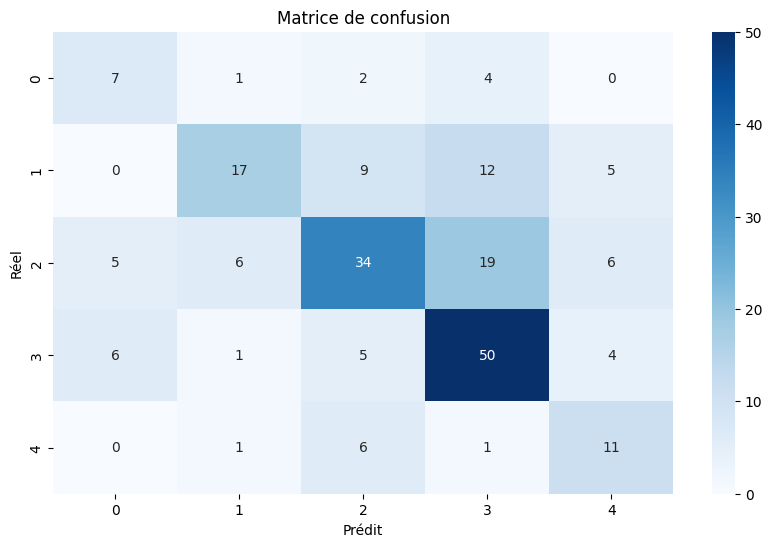

In [35]:
# Étape 1 : Chargement du DataFrame propre
# (Assure-toi que df_friches_silver est bien chargé)

# Étape 2 : Nettoyage (suppression des classes trop rares ou douteuses)
y = df_friches_silver['site_reconv_type']
X = df_friches_silver.drop(columns='site_reconv_type')

y = y.replace({ 5: -1, 0: -1, 8: -1, 7:-1 , 9:-1, 10: -1}) 
mask = y != -1
X = X[mask]
y = y[mask]

# Étape 3 : Nettoyage des colonnes non numériques
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

# Étape 4 : Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Étape 5 : Modèle avec pondération automatique
clf = RandomForestClassifier(
    n_estimators=400, #besoin de plus estimator ici
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',  # clé ici
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Évaluation
y_pred = clf.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# Étape 7 : Visualisation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# V2 : Classification avec Random Forrest et équilibrage (class_weight='balanced')

Accuracy : 0.6359743040685225

Classification Report :
               precision    recall  f1-score   support

           0       0.75      0.78      0.77       291
           1       0.44      0.50      0.47        14
           2       0.52      0.31      0.39        52
           4       0.55      0.45      0.50        66
           6       0.24      0.34      0.29        32
           7       0.25      0.20      0.22         5
          10       0.36      0.57      0.44         7

    accuracy                           0.64       467
   macro avg       0.44      0.45      0.44       467
weighted avg       0.64      0.64      0.63       467



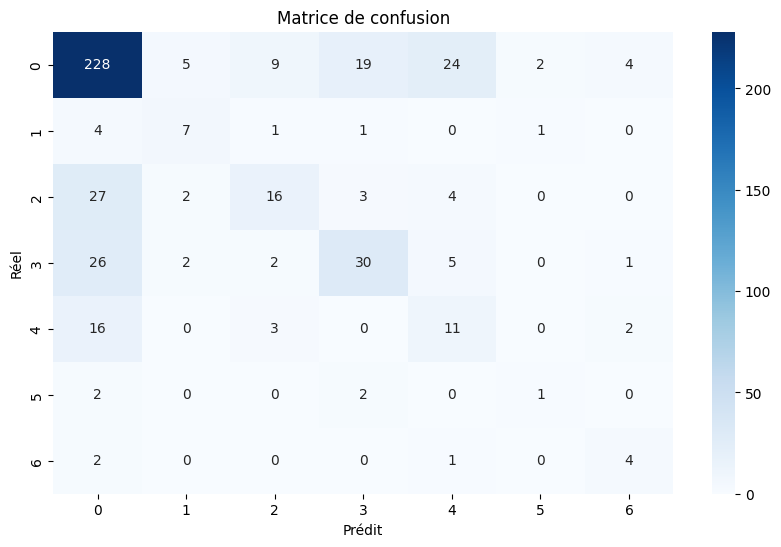

In [36]:
# Étape 1 : Chargement du DataFrame propre
# (Assure-toi que df_friches_silver est bien chargé)

# Étape 2 : Nettoyage (suppression des classes trop rares ou douteuses)
y = df_friches_silver['site_reconv_type']
X = df_friches_silver.drop(columns='site_reconv_type')

y = y.replace({3: 0, 
               5: 2, 
               8: 10, 
               9: 6, 
               }) 

#mask = y != -1
#X = X[mask]
#y = y[mask]

# Étape 3 : Nettoyage des colonnes non numériques
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

# Étape 4 : Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Étape 5 : Modèle avec pondération automatique
clf = RandomForestClassifier(
    n_estimators=400, #besoin de plus estimator ici
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',  # clé ici
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Évaluation
y_pred = clf.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# Étape 7 : Visualisation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# V3 : Classification avec Random Forrest et équilibrage (class_weight='balanced')

Accuracy : 0.6295503211991434

Classification Report :
                        precision    recall  f1-score   support

culturel, touristique       0.45      0.38      0.41        66
industrie, logistique       0.45      0.71      0.56         7
photovoltaïque au sol       0.20      0.20      0.20         5
          renauration       0.60      0.43      0.50        14
 résidentiel ou mixte       0.74      0.78      0.76       291
            tertiaire       0.30      0.53      0.38        32
    équipement public       0.62      0.25      0.36        52

             accuracy                           0.63       467
            macro avg       0.48      0.47      0.45       467
         weighted avg       0.64      0.63      0.62       467



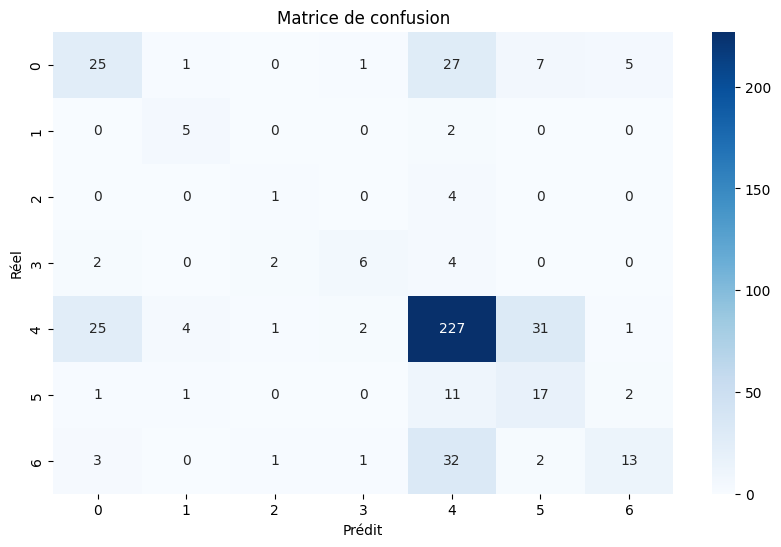

In [37]:
# Étape 1 : Chargement du DataFrame propre
# (Assure-toi que df_friches_silver est bien chargé)

# Étape 2 : Nettoyage (suppression des classes trop rares ou douteuses)
y = df_friches_silver['site_reconv_type']
X = df_friches_silver.drop(columns='site_reconv_type')

y = y.replace({0: "résidentiel ou mixte", 
               1: "renauration",
               2: "équipement public",
               3: "résidentiel ou mixte",
               4: "culturel, touristique",
               5: "équipement public",
               6: "tertiaire",
               7: "photovoltaïque au sol",
               8: "industrie, logistique",
               9: "tertiaire",
               10: "industrie, logistique"
               }) 

#mask = y != -1
#X = X[mask]
#y = y[mask]

# Étape 3 : Nettoyage des colonnes non numériques
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

# Étape 4 : Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Étape 5 : Modèle avec pondération automatique
clf = RandomForestClassifier(
    n_estimators=400, #besoin de plus estimator ici
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',  # clé ici
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Évaluation
y_pred = clf.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# Étape 7 : Visualisation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()